# Анализ результатов A/B тестирования

# Часть 0. Предобработка.

Подключим все библиотеки, прочитаем все файлы и посмотрим на них, исправим незначительные косячки.

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

#orders.columns = orders.columns.str.lower();
visitors.columns = visitors.columns.str.lower();

In [3]:
print(hypothesis.info())
hypothesis.columns = hypothesis.columns.str.lower();
hypothesis['reach'] = hypothesis['reach'].astype('int16');
hypothesis['impact'] = hypothesis['impact'].astype('int16');
hypothesis['confidence'] = hypothesis['confidence'].astype('int16');
hypothesis['efforts'] = hypothesis['efforts'].astype('int16');

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None


In [4]:
orders.columns = orders.columns.str.lower();
orders['date'] = orders['date'].astype('datetime64')
print(orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionid    1197 non-null int64
visitorid        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
None


In [5]:
visitors.columns = visitors.columns.str.lower();
visitors['visitors'] = visitors['visitors'].astype('int32')
visitors['date'] = visitors['date'].astype('datetime64')
print(visitors.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int32
dtypes: datetime64[ns](1), int32(1), object(1)
memory usage: 1.3+ KB
None


**Привели всё к нижнему регистру и изменили тип данных на менее ресурсозатратные.**

# Часть 1. Приоритизация гипотез.

In [6]:
hypothesis['ice'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis = hypothesis.sort_values(by = 'ice', ascending =False).reset_index(drop = True)
hypothesis

,hypothesis,reach,impact,confidence,efforts,ice
0,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000
1,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333
2,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000
3,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000
4,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000
5,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.000000
6,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.333333
7,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.125000
8,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.000000


In [7]:
hypothesis['rice'] =hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis = hypothesis.sort_values(by = 'rice' , ascending =False).reset_index(drop = True)
hypothesis

,hypothesis,reach,impact,confidence,efforts,ice,rice
0,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000,112.0
1,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000,56.0
2,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333,40.0
3,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000,40.0
4,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000,16.2
5,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.125000,9.0
6,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.000000,4.0
7,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.333333,4.0
8,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.000000,3.0


При изменении приоритезации от **ICE** к **RICE** результаты изменились. Теперь помимо силы гипотезы учитывается и то, как много пользователей она затронет, топ состоит из тех же гипотез, но они поменялись местами.

# Часть 2. Анализ A/B-теста
## Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

In [9]:
datesGroups = orders[['date','group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'transactionid' : pd.Series.nunique,
'visitorid' : pd.Series.nunique,
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [10]:
visitorsAggregated = datesGroups.apply(
lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [11]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


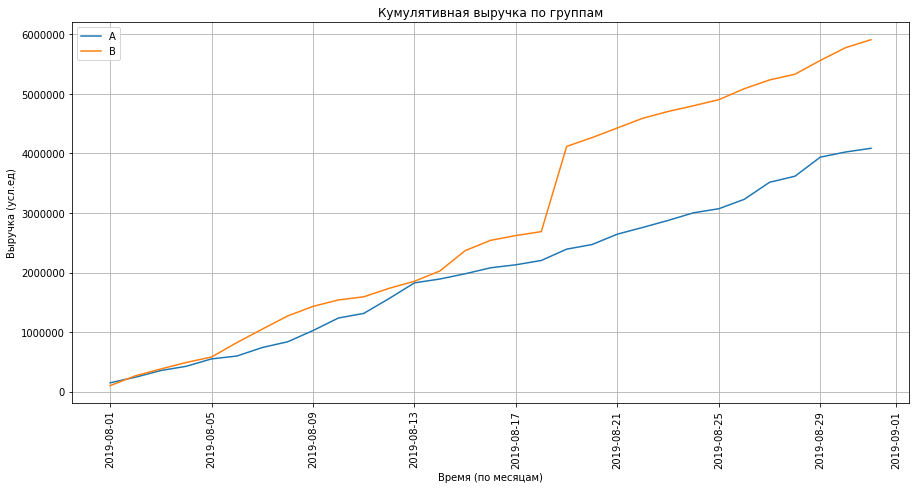

In [12]:
plt.figure(figsize=(15, 7));
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A');
# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B');
plt.xticks(rotation='vertical');
plt.title('Кумулятивная выручка по группам');
plt.legend();
plt.grid();

plt.xlabel('Время (по месяцам)')
plt.ylabel('Выручка (усл.ед)')
plt.show();


**Сегмент B лидирует в течение всего теста**, также в середине теста видно скачок сегмента B, связанный с аномально большими заказами.

## Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.

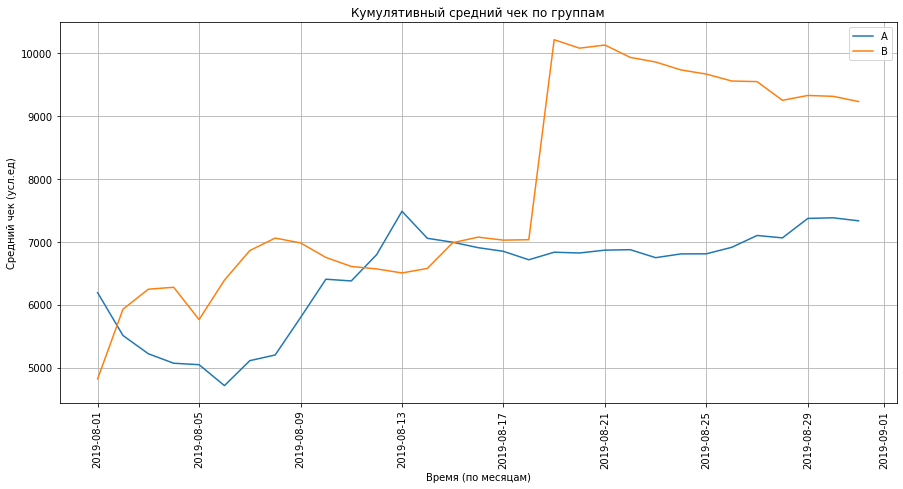

In [13]:
plt.figure(figsize=(15, 7))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'], label='A');
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders'], label='B');
plt.xticks(rotation='vertical');
plt.title('Кумулятивный средний чек по группам');
plt.legend();
plt.grid();
plt.xlabel('Время (по месяцам)')
plt.ylabel('Средний чек (усл.ед)')
plt.show();

**Средний чек продолжает колебаться, требуется дополнительный анализ выбросов, искажающих данные.**

## Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

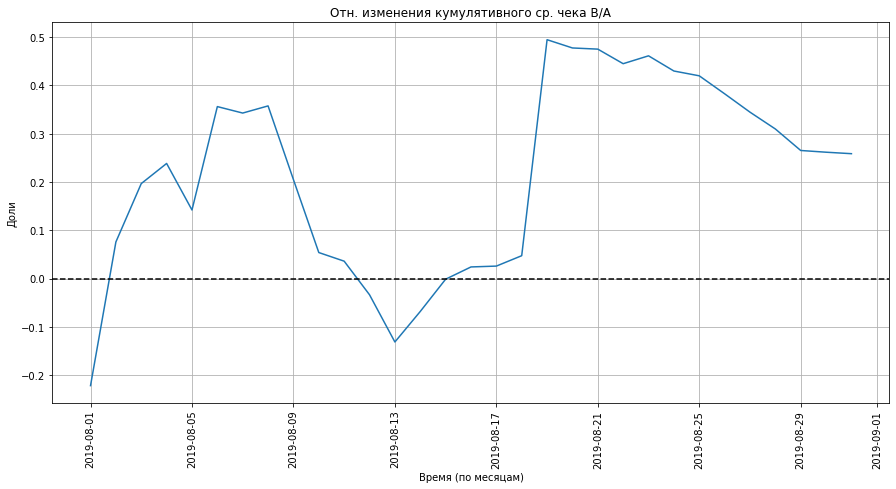

In [14]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(15, 7))

plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1);
# добавляем ось X

plt.axhline(y=0, color='black', linestyle='--') ;
plt.xticks(rotation='vertical');
plt.title('Отн. изменения кумулятивного ср. чека B/A');
plt.grid();

plt.xlabel('Время (по месяцам)')
plt.ylabel('Доли')
plt.show();

В начале теста результаты менялись резко, также резкий перепад был **2019-08-19**. Тем не менее заметно, что преимущественно  график лежит выше нуля, а значит, что **ср. чек группы B в среднем больше, чем средний чек группы А.**

## Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.

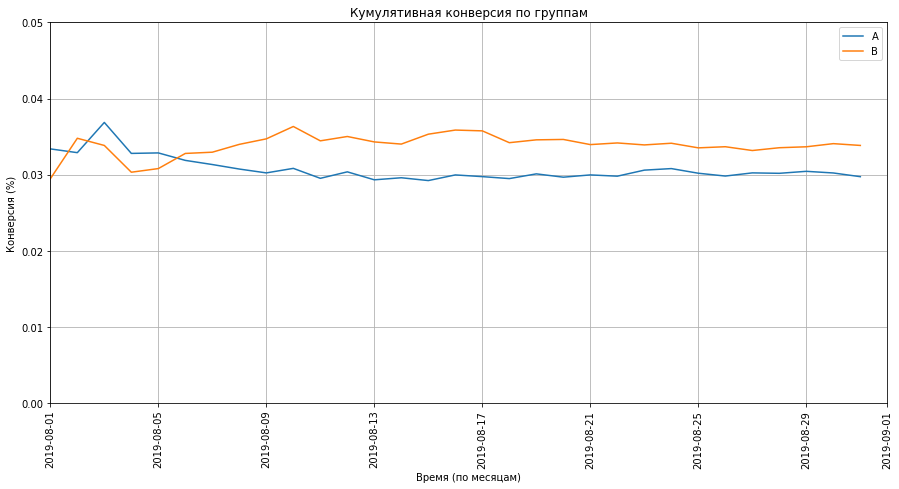

In [15]:
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']
# отделяем данные по группам:
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики:
plt.figure(figsize=(15, 7))

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A');
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B');
plt.legend();
plt.axis(["2019-08-01", '2019-09-01', 0, 0.05]);
plt.xticks(rotation='vertical');
plt.title('Кумулятивная конверсия по группам');
plt.grid();

plt.xlabel('Время (по месяцам)')
plt.ylabel('Конверсия (%)')
plt.show();


**В начале теста конверсия сегмента А была больше, но затем сегмент В выровнялся и зафиксировался больше сегмента А.**

## Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.

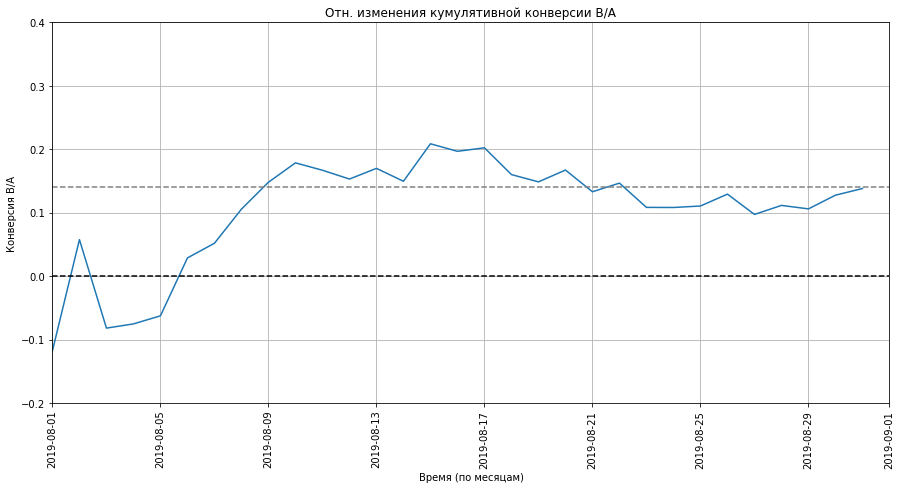

In [16]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B']);
plt.figure(figsize=(15, 7))

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1);

plt.axhline(y=0, color='black', linestyle='--');
plt.axhline(y=0.14, color='grey', linestyle='--');
plt.xticks(rotation='vertical');
plt.title('Отн. изменения кумулятивной конверсии В/А');
plt.grid();
plt.axis(["2019-08-01", '2019-09-01', -0.2, 0.4]);

plt.xlabel('Время (по месяцам)')
plt.ylabel('Конверсия B/A')
plt.show();

**Почти с самого начала теста группа В лидирует по конверсии, зафиксировалась около прироста в 14% относительно группы А.**

# Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

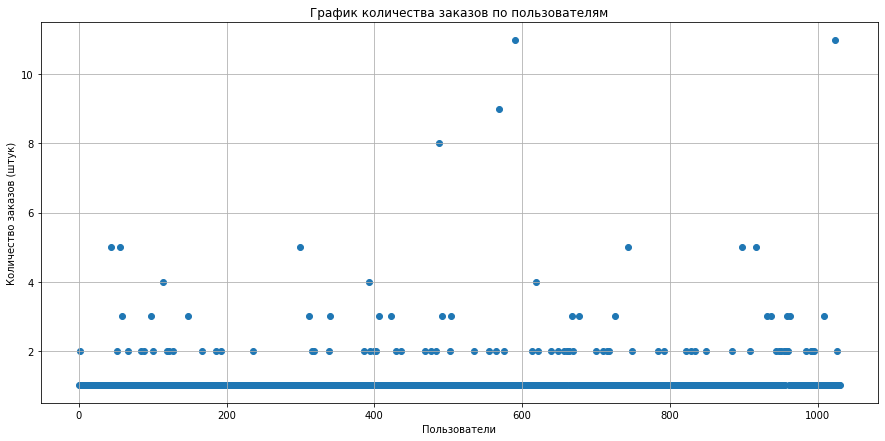

In [17]:
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsers.columns = ['visitorid','orders']
plt.figure(figsize=(15, 7))

# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']);
plt.title('График количества заказов по пользователям');
plt.grid();

plt.xlabel('Пользователи')
plt.ylabel('Количество заказов (штук)')
plt.show();

**Пользователей  заказавших более 2-х заказов мало. Это могут быть аномалии.**

# Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [18]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[2. 4.]


**Не более 5% совершали больше 2х покупок, и не более 1-го % более 4-х заказов.**.<br>
**Возьмем пороговое значение в 5%.**

# Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

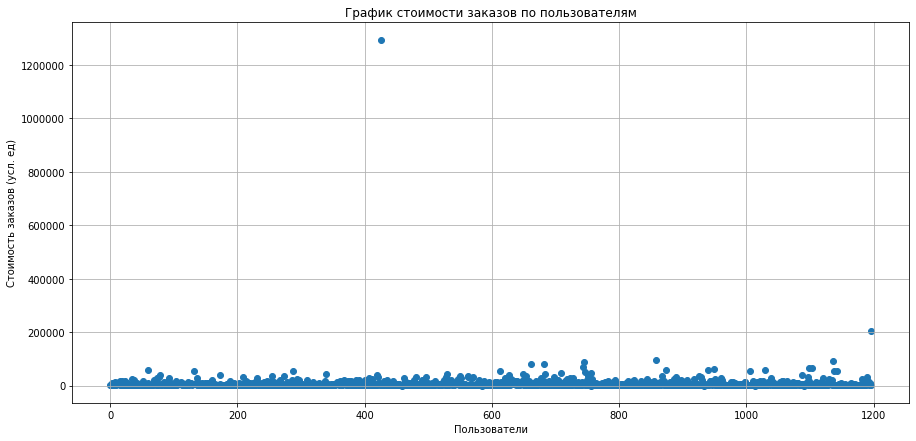

In [19]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(15, 7))
plt.scatter(x_values, orders['revenue']);
plt.title('График стоимости заказов по пользователям');
plt.grid();

plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказов (усл. ед)')
plt.show();

**Здесь видно 2 явных выброса в районе 200.000 и 1.300.000.**

# Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [20]:
print(np.percentile(orders['revenue'],  [95, 99])) 

[28000.  58233.2]


**Не более 5% заказов на сумму превышающую 28.000 и не более 1% на сумму большую 58.233**<br>
**Возьмем пороговое значение 5%**

# Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения.

H0: Статистически значимых различий в конверсии между группами для 'сырых' данных нет <br>
H1: Статистически значимые различия в конверсии между группами для 'сырых' данных есть. <br>
Уровень значимости альфа = 0.05

In [21]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']


In [22]:
ordersADaily = orders[orders['group']=='A'][['date', 'transactionid', 'visitorid', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionid' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']


In [23]:
ordersBDaily = orders[orders['group']=='B'][['date', 'transactionid', 'visitorid', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionid' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']


In [24]:
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

In [25]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorid', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorid', 'orders'] 

In [26]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 

In [27]:
results = stats.mannwhitneyu(sampleA, sampleB)
print('p-value:',"{0:.4f}".format(results.pvalue))
alpha = .05 
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-value: 0.0084
Отвергаем нулевую гипотезу


Анализ сырых данных показывает, что между группами A и B **есть статистически значимые различия**. (Для уровня значимости 0.05). Отвергаем нулевую гипотезу об отсутствии различий между конверсиями двух групп (для "сырых" данных). Посмотрим на относительные различия:

In [28]:
print("{0:.3f}".format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1)) 

0.138


**Конверсия сегмента В лучше конверсии сегмента А на 13,8%**.

# Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения

H0: Статистически значимых различий в средних чеках между группами для 'сырых' данных нет <br>
H1: Статистически значимые различия в средних чеках между группами для 'сырых' данных есть. <br>
Уровень значимости альфа = 0.05

In [29]:
results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])
print('p-value:',"{0:.4f}".format(results.pvalue))
alpha = .05 
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-value: 0.3646
Не получилось отвергнуть нулевую гипотезу


**Статистически значимых различий по среднему чеку между группами нет** (p-value > alpha = 0.05), посмотрим на относительные различия между средними чеками:

In [30]:
print("{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean() / orders[orders['group']=='A']['revenue'].mean()-1)) 

0.259


Относительное различие среднего чека между группами - 25.9%, если при таком большом проценте по критерию Манна- Уитни нет значимых отличий, значит этот процент набегает за счёт малого количества очень больших заказов группы B

# Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения.

H0: Статистически значимых различий в конверсии между группами для 'очищенных' данных нет <br>
H1: Статистически значимые различия в конверсии между группами для 'очищенных' данных есть. <br>
Уровень значимости альфа = 0.05

In [31]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorid'], ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorid']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorid']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorid'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorid'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0) 

In [32]:
results = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)
print('p-value:',"{0:.4f}".format(results.pvalue))
alpha = .05 
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-value: 0.0065
Отвергаем нулевую гипотезу


Анализ очищенных данных показывает, что между группами A и B **есть статистически значимые различия**. (Для уровня значимости 0.05). Отвергаем нулевую гипотезу об отсутствии различий между конверсиями двух групп (для "очищенных" данных) посмотрим на относительные различия конверсий:

In [34]:
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.173


**Теперь конверсия сегмента B стала лучше А на 17.3%**. Исключив пользователей совершивших больше 2-х заказов, результат так сильно изменился, видимо в группе А люди совершали более 2-х заказов чаще

# Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

H0: Статистически значимых различий в средних чеках между группами для 'очищенных' данных нет <br>
H1: Статистически значимые различия в средних чеках между группами для 'очищенных' данных есть. <br>
Уровень значимости альфа = 0.05

In [36]:
results = (stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue']))
print('p-value:',"{0:.4f}".format(results.pvalue))
alpha = .05 
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-value: 0.3692
Не получилось отвергнуть нулевую гипотезу


**Статистически значимых различий по среднему чеку между группами по-прежнему  нет** (p-value > 0.05), посмотрим на относительные различия между средними чеками:

In [35]:
print("{0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'].mean() - 1)) 

-0.020


**Исключив выбросы**, о которых мы говорили ранее, оценивая средний чек, **мы получили, что средний чек сегмента B на 2% меньше чем у сегмента А**

# Примите решение по результатам теста и объясните его.

## Повторим предыдущие шаги, только для фильтрованных значений:

In [36]:
ordersFiltred = orders[orders['revenue'] < 28000].reset_index(drop = True)
FiltredUserd = pd.concat([ordersByUsersA[ordersByUsersA['orders'] <= 2]['visitorid'], ordersByUsersB[ordersByUsersB['orders'] <= 2]['visitorid']], axis = 0)
ordersFiltred = ordersFiltred[ordersFiltred['visitorid'].isin(FiltredUserd)].reset_index(drop = True)

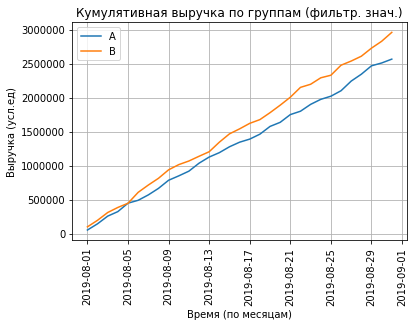

In [37]:
datesGroups = ordersFiltred[['date','group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: ordersFiltred[np.logical_and(ordersFiltred['date'] <= x['date'], ordersFiltred['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'transactionid' : pd.Series.nunique,
'visitorid' : pd.Series.nunique,
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

visitorsAggregated = datesGroups.apply(
lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A');
# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B');
plt.xticks(rotation='vertical');
plt.title('Кумулятивная выручка по группам (фильтр. знач.)');
plt.legend();
plt.grid();

plt.xlabel('Время (по месяцам)')
plt.ylabel('Выручка (усл.ед)')
plt.show();

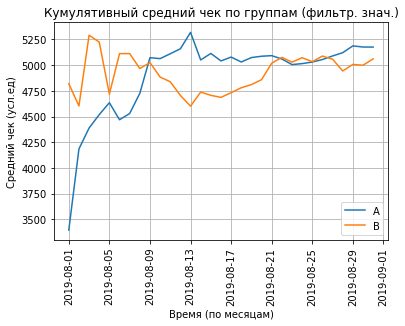

In [38]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'], label='A');
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders'], label='B');
plt.xticks(rotation='vertical');
plt.title('Кумулятивный средний чек по группам (фильтр. знач.)');
plt.legend();
plt.grid();

plt.xlabel('Время (по месяцам)')
plt.ylabel('Средний чек (усл.ед)')
plt.show();

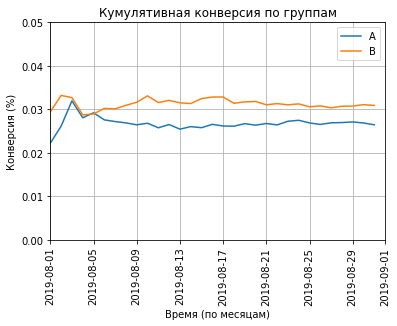

In [39]:
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']
# отделяем данные по группам:
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики:
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A');
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B');
plt.legend();
plt.axis(["2019-08-01", '2019-09-01', 0, 0.05]);
plt.xticks(rotation='vertical');
plt.title('Кумулятивная конверсия по группам');
plt.grid();
plt.xlabel('Время (по месяцам)')
plt.ylabel('Конверсия (%)')
plt.show();

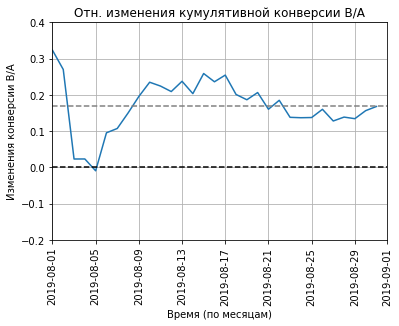

In [40]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B']);

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1);

plt.axhline(y=0, color='black', linestyle='--');
plt.axhline(y=0.17, color='grey', linestyle='--');
plt.xticks(rotation='vertical');
plt.title('Отн. изменения кумулятивной конверсии В/А');
plt.grid();
plt.axis(["2019-08-01", '2019-09-01', -0.2, 0.4]);

plt.xlabel('Время (по месяцам)')
plt.ylabel('Изменения конверсии B/A')
plt.show();

### Вывод: тест нужно останавливать, он прошёл успешно, группа В приносит больше выручки.
По результатам проведения А/В теста заметно, что выручка группы В больше, чем у группы А, это связано с тем, что конверсия группы В больше конверсии группы А на 17.3%, средний чек же в обеих группах отличается не слишком сильно и, в засисимости от периода, сначала лидирует В потом А, на большем промежутке вероятно они продолжут колебаться, в целом, по этим показателям ясно, что **тест нужно останавливать, он прошёл успешно, группа В приносит больше выручки.**